## Simple Exponential Smoothing

In [1]:
from sktime.datasets import load_shampoo_sales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from statsmodels.tsa.api import SimpleExpSmoothing
from functions import mae
from scipy.optimize import minimize


## 0. Load data

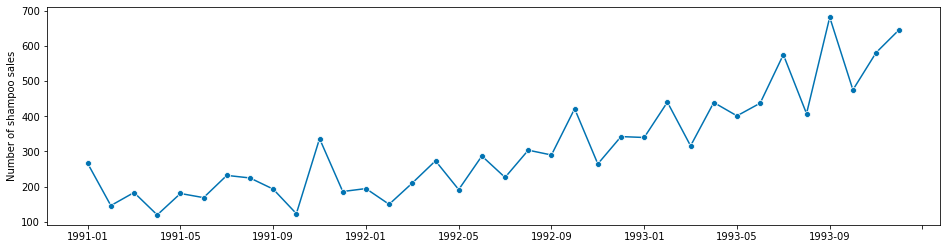

In [2]:
X = load_shampoo_sales()
fig, ax =  plot_series(X)

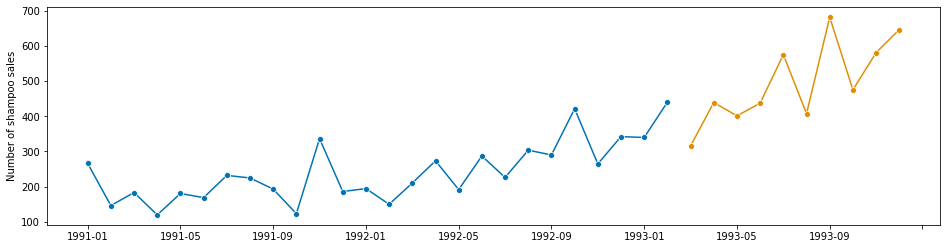

In [3]:
window = 10
y_train, y_test = X[:-window], X[-window:]
fig, ax = plot_series(y_train, y_test)

## 1. Simple Exponential Smoothing 

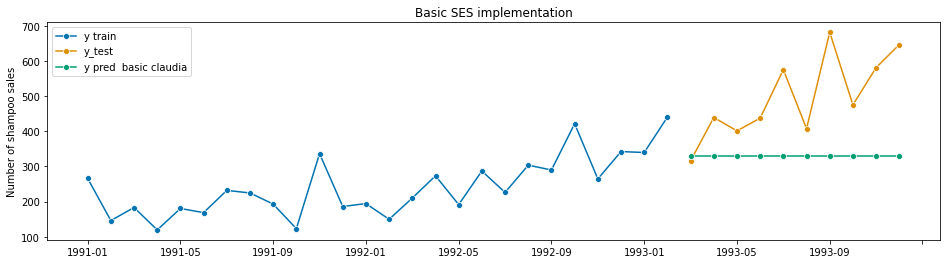

In [4]:
def SES(y, h, l0 = 100, alpha = 0.2):
    T = len(y)
    js = np.arange(0,T)
    return np.repeat(np.sum(alpha*np.power(1-alpha, js)*y[::-1])+np.power((1-alpha), T)*l0, window)

y_pred_claudia_basic = SES(y_train, window)
fig, ax = plot_series(y_train, y_test, pd.Series(y_pred_claudia_basic, index=y_test.index), labels=["y train", "y_test", "y pred  basic claudia"])
ax.set_title("Basic SES implementation")
plt.show()

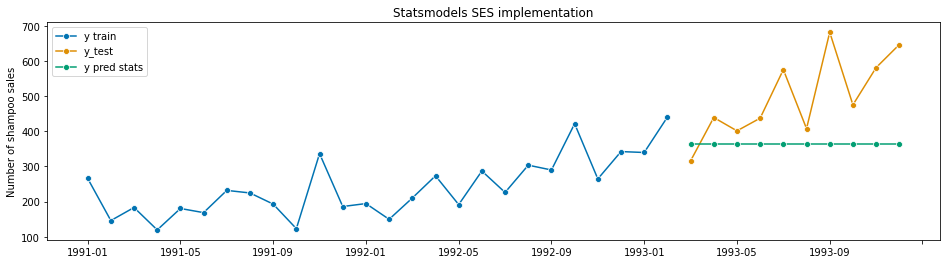

In [5]:
model = SimpleExpSmoothing(y_train)
model = model.fit()
y_pred_stats = model.forecast(window)
fig, ax = plot_series(y_train, y_test, pd.Series(y_pred_stats, index=y_test.index), labels=["y train", "y_test", "y pred stats"])
ax.set_title("Statsmodels SES implementation")
plt.show()

In [6]:
print("MAE Basic Claudia model: {}".format(mae(y_test, y_pred_claudia_basic)))
print("MAE Stats model: {}".format(mae(y_test, y_pred_stats)))

MAE Basic Claudia model: 169.4729889078793
MAE Stats model: 142.9734577368383


## 2. SES with optimized parameters

In [7]:
alpha_stats = model.params['smoothing_level']
l0_stats = model.params['initial_level']
alpha_stats, l0_stats

(0.33605025201590205, 198.4177124386768)

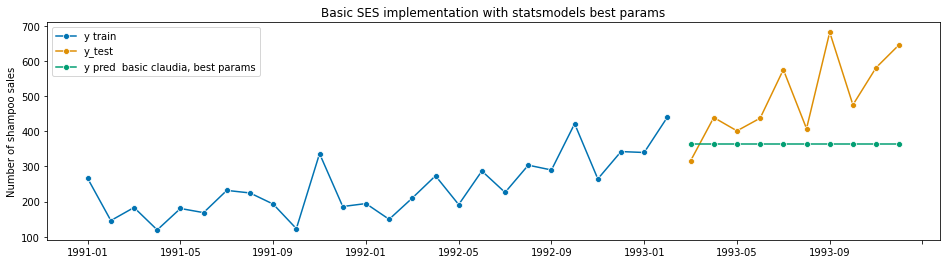

In [8]:
y_pred_claudia_basic_2 = SES(y_train, window, l0_stats, alpha_stats)
fig, ax = plot_series(y_train, y_test, pd.Series(y_pred_claudia_basic_2, index=y_test.index), labels=["y train", "y_test", "y pred  basic claudia, best params"])
ax.set_title("Basic SES implementation with statsmodels best params")
plt.show()

In [9]:
print("MAE Basic Claudia model: {}".format(mae(y_test, y_pred_claudia_basic_2)))
print("MAE Stats model: {}".format(mae(y_test, y_pred_stats)))

MAE Basic Claudia model: 142.97345773683827
MAE Stats model: 142.9734577368383


In [10]:
def SimpExpSmooth_SSE(x, y_train):
    l0 = x[0]
    alpha = x[1]
    addition = 0
    T = len(y_train)
    for t in range(2,T+1): #reaches T+1
        a = y_train[t-1]
        b = np.sum(alpha*np.power(1-alpha, np.arange(0,t-1, 1))*y_train[:t-1].values[::-1])
        c = np.power(1-alpha, t-1)*l0
        addition = addition + np.square(a-b-c)
    return addition

In [11]:
x0 = [1,1]
bnds = ((None, None), (0,1))
res = minimize(SimpExpSmooth_SSE, x0,args = y_train, bounds=bnds, options={'gtol': 1e-4, 'disp': True})

In [12]:
l0, alpha = res.x
l0, alpha

(105.99329354490517, 0.3561631855663435)

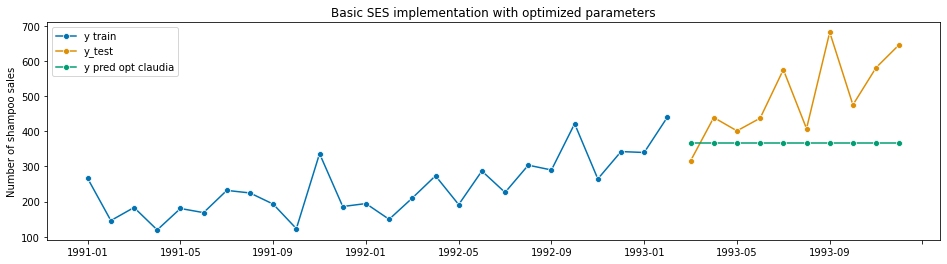

In [13]:
y_pred_claudia_opt = SES(y_train, window, l0, alpha)
fig, ax = plot_series(y_train, y_test, pd.Series(y_pred_claudia_opt, index=y_test.index), labels=["y train", "y_test", "y pred opt claudia"])
ax.set_title("Basic SES implementation with optimized parameters")
plt.show()

In [14]:
print("MAE Basic Claudia model: {}".format(mae(y_test, y_pred_claudia_opt)))
print("MAE Stats model: {}".format(mae(y_test, y_pred_stats)))

MAE Basic Claudia model: 140.19762572908763
MAE Stats model: 142.9734577368383


In [15]:
class SES:
    @staticmethod
    def SSE_loss(x, *args):
        y_train, alpha, l0 = args[0], args[1], args[2]
        if l0==None and alpha==None:
            l0, alpha = x[0], x[1]
        elif l0!=None and alpha==None: 
            alpha=x[0]
        elif l0==None and alpha!=None:
            l0=x[0]
        addition = 0
        T = len(y_train)
        for t in range(2,T+1): #reaches T+1
            a = y_train[t-1]
            b = np.sum(alpha*np.power(1-alpha, np.arange(0,t-1, 1))*y_train[:t-1].values[::-1])
            c = np.power(1-alpha, t-1)*l0
            addition = addition + np.square(a-b-c)
        return addition

    def fit(self, y_train, alpha = None, l0=None):
        self.y_train = y_train
        arguments = (y_train, alpha, l0)
        if alpha == None and l0==None:
            x0 = [1,1]
            bnds = ((None, None), (0,1))
            res = minimize(self.SSE_loss, x0,args = arguments, bounds=bnds, options={'gtol': 1e-4})
            self.l0, self.alpha = res.x
        elif alpha!=None and l0==None:
            self.alpha = alpha
            x0 = [1]
            res = minimize(self.SSE_loss, x0,args = arguments, options={'gtol': 1e-4})
            self.l0 = res.x
        elif alpha==None and l0!=None:
            self.l0 = l0
            x0 = [1]
            res = minimize(self.SSE_loss, x0,args = arguments, options={'gtol': 1e-4})
            self.alpha = res.x
        elif alpha != None and l0 != None:
            self.alpha = alpha
            self.l0 = l0
        else:
            print("Either optimize parameters or specify desired alpha and initial level")
        return self
    def predict(self, fh):
        T = len(self.y_train)
        js = np.arange(0,T)
        return np.repeat(np.sum(self.alpha*np.power(1-self.alpha, js)*self.y_train[::-1])+np.power((1-self.alpha), T)*self.l0, fh)


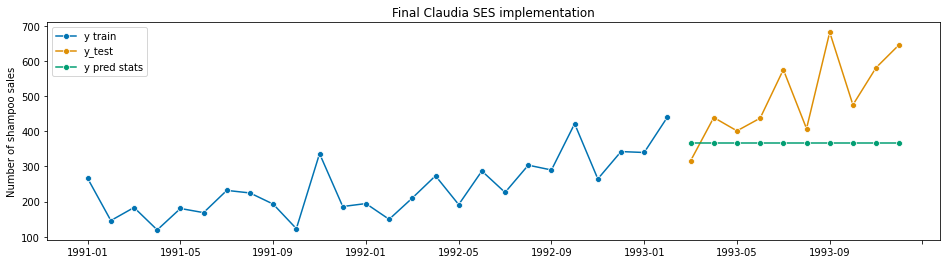

In [16]:
model = SES()
model = model.fit(y_train)
y_pred_final = model.predict(window)
fig, ax = plot_series(y_train, y_test, pd.Series(y_pred_final, index=y_test.index), labels=["y train", "y_test", "y pred stats"])
ax.set_title("Final Claudia SES implementation")
plt.show()

In [17]:
print("MAE Final Claudia model: {}".format(mae(y_test, y_pred_final)))
print("MAE Stats model: {}".format(mae(y_test, y_pred_stats)))

MAE Final Claudia model: 140.19762572908763
MAE Stats model: 142.9734577368383
